Kevin Frans' [solution](https://github.com/kvfrans/Easy21-RL) to [Easy21](https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf).

In [40]:
# environment.py

import random
import numpy as np

class State:
    dealercard = random.randint(1,10)
    playersum = random.randint(1,10)

# adds some drawn card value
def drawcard(current):
    if random.randint(1,3) < 3:
        current += random.randint(1,10)
    else:
        current -= random.randint(1,10)
    return current

# action {0: stick, 1: hit}
def step(state, action):
    if action == 1:
        state.playersum = drawcard(state.playersum)
        if state.playersum < 1 or state.playersum > 21:
            return "terminal", -1.0
        else:
            return state, 0
    elif action == 0:
        while(state.dealercard < 17):
            state.dealercard = drawcard(state.dealercard)
            if state.dealercard < 1 or state.dealercard > 21:
                return "terminal", 1.0
        if state.dealercard > state.playersum:
            return "terminal", -1.0
        elif state.dealercard < state.playersum:
            return "terminal", 1.0
        else:
            return "terminal", 0.0

In [41]:
# montecarlo.py

def montecarlo(value,counter):
    state = State()
    state.playersum = random.randint(1,10)
    state.dealercard = random.randint(1,10)
    totalreward = 0
    visits = []
    while state != "terminal":
        action = None
        e = 100.0 / (100.0 + np.sum(counter[:,state.dealercard, state.playersum],axis=0))
        if (random.random() < e):
            action = random.randint(0,1)
        else:
            action = np.argmax(value[:, state.dealercard, state.playersum])
        counter[action, state.dealercard, state.playersum] += 1
        visits.append((action, state.dealercard, state.playersum))
        state, reward = step(state, action)
        totalreward += reward
    # since the only reward is at the end, doesn't matter when we visited the state
    # print(f'{visits} => {reward}')
    for action, dealercard, playersum in visits:
        a = 1 / counter[action,dealercard,playersum]
        g = totalreward
        # print "section"
        # print a*(g - value[action,dealercard,playersum])
        value[action,dealercard,playersum] = value[action,dealercard,playersum] + a*(g - value[action,dealercard,playersum])
        # print value[action,dealercard,playersum]
    return value, counter

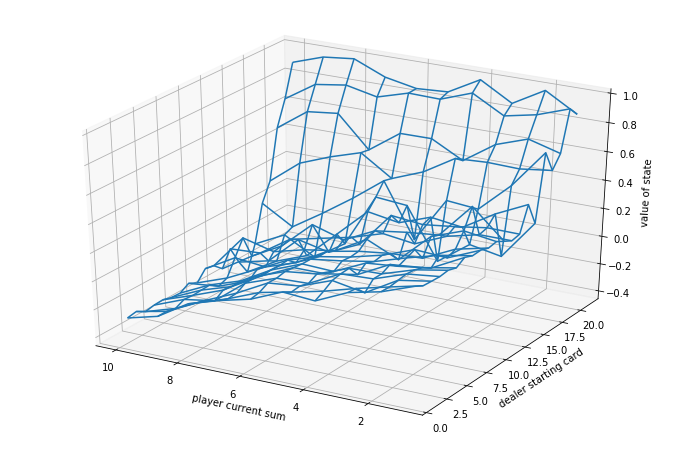

In [65]:
# plot for MC control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# the same random seed so that I am able to compare Kevin's results with mine.
random.seed(20200403)

# value[action][dealercard][playersum] is the value function, table lookup should work with so little states
value = np.zeros((2,11,22))
counter = np.zeros((2,11,22))

# run monte-carlo
for i in range(200000):
     value, counter = montecarlo(value,counter)

# plot monte-carlo value func
fig = plt.figure(figsize=(12, 8))
ha = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(range(1, 11), range(1, 22))
Z = np.array([np.max(value[:, d, p]) for (d, p) in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

ha.plot_wireframe(X, Y, Z)
ha.invert_xaxis()
ha.set_ylabel("dealer starting card")
ha.set_xlabel("player current sum")
ha.set_zlabel("value of state")

plt.show()